In [1]:
#general

import pandas as pd
import numpy as np
import os
import pickle
import time
import sys


import tensorflow as tf

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import reset_graph

from functools import partial

from tan.tan_util import get_tan_nll as tan
from tan.tan_util import get_tan_nll_cond as tan_cond

from tensorflow.contrib.slim.nets import resnet_v2
import imagenet_helper_files.vgg_preprocessing
import tensorflow.contrib.slim as slim

#For parsing records once written
from Utilities.set_record_parser import build_set_dataset
from Utilities.set_record_parser import get_file_lists
from Utilities.models import log_dir_build
import pickle

c:\users\sdgeo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Setup Directories 

Here we are going to get the files needed to do the project

In [2]:
#Locate Neccesary Files
homogenous_train = open("D:/Machine_Learning/Datasets/cortical_images/L/Original_Images_Train.pkl", "rb")
nonhomogenous_train = open("D:/Machine_Learning/Datasets/cortical_images/L/Inhomogeneous_Images_Train.pkl", "rb")
homogenous_test = open("D:/Machine_Learning/Datasets/cortical_images/L/Original_Images_Test.pkl", "rb")
nonhomogenous_test = open("D:/Machine_Learning/Datasets/cortical_images/L/Inhomogeneous_Images_Test.pkl", "rb")
train_homog_l = pickle.load(homogenous_train)
train_homog_labels_l = np.zeros(train_homog_l.shape[0])
train_nonhomog_l = pickle.load(nonhomogenous_train)
train_nonhomog_labels_l = np.ones(train_nonhomog_l.shape[0])
test_homog_l = pickle.load(homogenous_test)
test_homog_labels_l = np.zeros(test_homog_l.shape[0])
test_nonhomog_l = pickle.load(nonhomogenous_test)
test_nonhomog_labels_l = np.ones(test_nonhomog_l.shape[0])
homogenous_train.close()
nonhomogenous_train.close()
homogenous_test.close()
nonhomogenous_test.close()
#Locate Neccesary Files
homogenous_train = open("D:/Machine_Learning/Datasets/cortical_images/R/Original_Images_Train.pkl", "rb")
nonhomogenous_train = open("D:/Machine_Learning/Datasets/cortical_images/R/Inhomogeneous_Images_Train.pkl", "rb")
homogenous_test = open("D:/Machine_Learning/Datasets/cortical_images/R/Original_Images_Test.pkl", "rb")
nonhomogenous_test = open("D:/Machine_Learning/Datasets/cortical_images/R/Inhomogeneous_Images_Test.pkl", "rb")
train_homog_r = pickle.load(homogenous_train)
train_homog_labels_r = np.zeros(train_homog_r.shape[0])
train_nonhomog_r = pickle.load(nonhomogenous_train)
train_nonhomog_labels_r = np.ones(train_nonhomog_r.shape[0])
test_homog_r = pickle.load(homogenous_test)
test_homog_labels_r = np.zeros(test_homog_r.shape[0])
test_nonhomog_r = pickle.load(nonhomogenous_test)
test_nonhomog_labels_r = np.ones(test_nonhomog_r.shape[0])
homogenous_train.close()
nonhomogenous_train.close()
homogenous_test.close()
nonhomogenous_test.close()

In [3]:
#combine into full train and test set as well as ground truth
full_train = np.concatenate((train_homog_l, train_nonhomog_l, train_homog_r, train_nonhomog_r), axis = 0)
full_train_labels = np.concatenate((train_homog_labels_l, train_nonhomog_labels_l, train_homog_labels_r, train_nonhomog_labels_r), axis=0)

full_test = np.concatenate((test_homog_l, test_nonhomog_l, test_homog_r, test_nonhomog_r), axis = 0)
full_test_labels = np.concatenate((test_homog_labels_l, test_nonhomog_labels_l, test_homog_labels_r, test_nonhomog_labels_r), axis=0)

In [12]:
image_1 = full_test[0]
full_test.shape
!pwd

/cygdrive/c/Users/sdgeo/Dropbox/Own/Graduate-School/Second_Semester/Comp_790/generative_sets


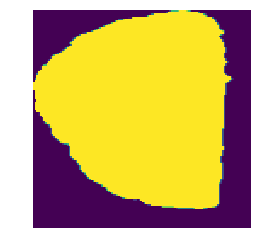

In [14]:
#Show and Image from set
x_val = full_test[0][2]

from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.axis('off')
plt.savefig('Brain_3.jpg')

# Design Neural Network

The following provides the code to import and use the TF_Records for the set project

In [5]:
#directory for logs in training
set_net_logs = 'D:/AI/models/set_project_brain_code_pca/logs'
model_path = log_dir_build(set_net_logs, "set_project_brain_code_pca")
#model_path = 'D:/AI/models/set_project_brain/logs/set_project-run-20190306174848/'

#directory for all the models saved during training
pca_model = 'D:/AI/models/set_project_brain_code_pca/model/' + 'set_pca'
set_net_model = 'D:/AI/models/set_project_brain_code_pca/model/' + 'set_project'
set_net_model_best = 'D:/AI/models/set_project_brain_code_pca/model/' + 'set_project_best'

In [6]:
def deep_set_layer(input_code, input_size, condense_size, set_size=3, layer_name='default', activation_func=tf.nn.sigmoid):
    
    learned_transform = tf.get_variable(layer_name + '_transform', shape=[input_size,condense_size], 
                                        trainable=True, initializer=tf.contrib.layers.variance_scaling_initializer()) 
    batched_transform = tf.broadcast_to(learned_transform, [tf.shape(input_code)[0], input_size, condense_size])
    transform_layer = tf.matmul(input_code, batched_transform)
    activation = activation_func(transform_layer)
    
    
    lambda_1 = tf.get_variable(layer_name + "_lambda", [condense_size], trainable=True, dtype=tf.float32, initializer=tf.initializers.random_normal(mean=1))
    lambda_1_transformed = tf.broadcast_to(lambda_1, [set_size, condense_size])
    multipy_pairwise = tf.broadcast_to(lambda_1_transformed, [tf.shape(input_code)[0], set_size, condense_size])
    
    sigma_1 = tf.abs(tf.get_variable(layer_name + "_sigma", [condense_size], trainable=True, dtype=tf.float32, initializer=tf.initializers.random_normal(mean=0)))
    sigma_1_tranformed = tf.broadcast_to(sigma_1, [tf.shape(input_code)[0], condense_size])
    

    # + sigma * mean(Data)
    max_pool_1 = tf.reduce_mean(activation, axis=1)
    sum_term = tf.multiply(sigma_1_tranformed, max_pool_1)
    sum_term_final = tf.expand_dims(sum_term, axis=1)  
    
    pre_activation_1 = tf.multiply(activation, multipy_pairwise) + sum_term_final
    layer_1 = activation_func(pre_activation_1)
    return layer_1

def PCA_Network(Input_Data, reuse = None):
    with tf.variable_scope("PCA", reuse=reuse):
        code_size = 10
        pca_learning_rate = 1
        code_layer_size = 16384
        with tf.name_scope("Original_Coding"):
            pca_code_layer = tf.layers.flatten(Input_Data)
            batch_mean = tf.expand_dims(tf.reduce_mean(pca_code_layer,0),0)
            pca_code_normalized = tf.subtract(pca_code_layer, batch_mean)

        with tf.name_scope("PCA_Layer"):
            reduction_matrix = tf.get_variable("weights", shape = [code_layer_size, code_size], initializer = tf.random_normal_initializer())
            Code = tf.matmul(pca_code_normalized,reduction_matrix, name="multipy")

        with tf.name_scope("Reconstruction_Layer_Final"):
            final_reconstruction_layer_bn = tf.matmul(Code, tf.transpose(reduction_matrix))
            final_reconstruction_layer = tf.add(final_reconstruction_layer_bn,batch_mean)

        with tf.name_scope("PCA_Loss"):
            pca_loss = tf.losses.mean_squared_error(final_reconstruction_layer,pca_code_layer)
            pca_loss_summary = tf.summary.scalar('pca_loss_summary', pca_loss)


        with tf.name_scope("PCA_Train"):
            pca_optimizer = tf.train.AdamOptimizer(learning_rate=pca_learning_rate, name='pca_optomizer')
            pca_global_step = tf.Variable(0, trainable=False, name='pca_global_step')
            training_op_pca = pca_optimizer.minimize(pca_loss, global_step=pca_global_step, name="training_op")

        saver_pca = tf.train.Saver(name="PCA_Saver")
        return Code, pca_loss, pca_loss_summary, training_op_pca, saver_pca

def PCA_Trainer(Input_Data):
    Code, pca_loss, pca_loss_summary, training_op_pca, saver_pca = PCA_Network(Input_Data, reuse = tf.AUTO_REUSE)
    return Code, pca_loss, pca_loss_summary, training_op_pca, saver_pca

def PCA_encode(Input_Data):
    Code, pca_loss, pca_loss_summary, training_op_pca, saver_pca = PCA_Network(Input_Data, reuse = tf.AUTO_REUSE)
    return Code


In [7]:
reset_graph()

#Placeholder for choosing input, epochs, batches, and datasets at runtime
learning_rate_class = .01
dropout_rate = 0.2
set_size = 3
    
with tf.name_scope('Data_Retrieval'):
    #put the data in the graph
    batch_size = tf.placeholder_with_default(30, shape=[], name= "Batch_Size")
    training = tf.placeholder_with_default(True, shape=(), name = 'training')
    
    data_set = tf.placeholder(shape=[None, 3, 128, 128], name="All_Data", dtype=tf.float32)
    single_data = tf.placeholder(shape=[None, 128, 128], name="Single_Data", dtype=tf.float32)
    data_label = tf.placeholder(shape=[None], name="Data_Labels", dtype=tf.int32)  

    
with tf.variable_scope("PCA_Code_Maker"):
    Code, pca_loss, pca_loss_summary, training_op_pca, saver_pca = PCA_Trainer(single_data)
    pca_code = tf.map_fn(lambda x: PCA_encode(x), data_set)


with tf.name_scope("BN_Layer_AE_Layers"):
    #Define initalizer and batch normalization layers
    bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
    he_init = tf.contrib.layers.variance_scaling_initializer()    
    

with tf.name_scope("Set_Analyzer"):
    #the network for generating output of our set
    with tf.name_scope('Unique_Identify'):
        code_size = 10
        n_layer_1 = 100
        n_layer_2 = 50
        n_layer_3 = 25
        n_unq_1 = 15
        n_unq_2 = 10
        n_unq_final = 2
        deep_activation = tf.nn.relu
        
        batch_item = batch_size
        encoding = tf.stop_gradient(pca_code)
        
        with tf.name_scope('DeepSet_Layer_1'):
            #1000
            deep_1 = deep_set_layer(encoding, code_size, n_layer_1, set_size=3, layer_name='Deep_One', activation_func=deep_activation)
        
        with tf.name_scope('DeepSet_Unq_Layer_1'):
            #500 Output
            deep_unq_1 = deep_set_layer(deep_1, n_layer_1, n_layer_2, set_size=3, layer_name='Deep_Unq_One', activation_func=deep_activation)
            
        with tf.name_scope('DeepSet_Unq_Layer_2'):
            #250 Output
            deep_unq_2 = deep_set_layer(deep_unq_1, n_layer_2, n_layer_3, set_size=3, layer_name='Deep_Unq_Two', activation_func=deep_activation)
            
        with tf.name_scope('Final_Unq_Deep_Pool'):
            #250 Output
            final_unq_deep_layer = tf.reduce_sum(deep_unq_2, 1)
            
        with tf.name_scope("Unq_Hidden_Layer_1"):
            #100 Output
            hidden1_unq = tf.layers.dense(final_unq_deep_layer, n_unq_1, name="hidden1_unq", kernel_initializer=he_init)
            hidden1_drop_unq = tf.layers.dropout(hidden1_unq, dropout_rate, training=training)
            hidden1_cast_unq = tf.cast(hidden1_drop_unq, tf.float32)
            bn1_cat_unq = bn_batch_norm_layer(hidden1_cast_unq)
            bn1_act_cat_unq = tf.nn.relu(bn1_cat_unq)  
            
        with tf.name_scope("Unq_Hidden_Layer_2"):
            #10 Output
            hidden2_unq = tf.layers.dense(bn1_act_cat_unq, n_unq_2, name="hidden2_unq", kernel_initializer=he_init)
            hidden2_drop_unq = tf.layers.dropout(hidden2_unq, dropout_rate, training=training)
            bn2_cat_unq = bn_batch_norm_layer(hidden2_drop_unq)
            bn2_act_cat_unq = tf.nn.relu(bn2_cat_unq)  
        
        
        with tf.name_scope("Final_Layer_unq"): 
            #Get softmax
            logits_before_bn_unq = tf.layers.dense(bn2_act_cat_unq, n_unq_final, name="outputs_unq")
            logits_unq = bn_batch_norm_layer(logits_before_bn_unq, name="logits_unq")
            softmax_unq = tf.nn.softmax(logits_unq, name="final_soft_max_unq")
            
            
        with tf.name_scope("Unique_loss"):           
            
            #Get cross entropy from labels
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=data_label, logits=logits_unq)
            loss_unq = tf.reduce_mean(xentropy, name="loss_unq")
            loss_summary_unq = tf.summary.scalar('loss_summary_unq', loss_unq)
            
        with tf.name_scope("eval_unq"):
            correct = tf.nn.in_top_k(logits_unq, data_label, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
            accuracy_summary = tf.summary.scalar('accuracy_summary', accuracy)
                
        with tf.name_scope("unique_train"):
            global_step_unique = tf.Variable(0, trainable=False, name='global_step_unique')
            optimizer_unq = tf.train.AdamOptimizer(learning_rate=learning_rate_class)

            extra_update_ops_unq = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            with tf.control_dependencies(extra_update_ops_unq):
                 training_op_unq = optimizer_unq.minimize(loss_unq, global_step=global_step_unique)

init = tf.global_variables_initializer()    
saver_total = tf.train.Saver(name="Full_Graph")

In [8]:
#Write Graph to log directory
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

In [9]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print(total_parameters)

172066


In [10]:
#Initialize the network

with tf.Session() as sess:
    init.run()
    saver_total.save(sess, set_net_model)
    saver_total.save(sess, set_net_model_best)
    saver_pca.save(sess, pca_model)
   

In [11]:
print(model_path)

D:/AI/models/set_project_brain_code_pca/logs/set_project_brain_code_pca-run-20190422003209/


# Train the PCA

Here we are going to train the network to do PCA

In [12]:
epochs = 500
steps_between_test_save = 5
batch = 10
all_data_steps = 20
worst_loss = 12000

start_time = time.time()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    #restore saver, build iterator, set the step to the global step
    saver_total.restore(sess, set_net_model)
    
    #Set up the global steps
    step = 1
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):
            idx = np.random.randint(full_train.shape[0], size=batch)
            batch_train = full_train[idx,:]
            batch_train_label = full_train_labels[idx]
            pca_train = np.reshape(np.ravel(batch_train), (batch_train.shape[0] * batch_train.shape[1], 128,128))
            
            #run Training Op
            sess.run([training_op_pca], feed_dict={single_data: pca_train})

        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0) :
            idx = np.random.randint(full_test.shape[0], size=batch)
            batch_test = full_test[idx,:]
            batch_test_label = full_test_labels[idx]
            pca_test = np.reshape(np.ravel(batch_test), (batch_test.shape[0] * batch_test.shape[1], 128,128))
            
            l, l_sum = sess.run([pca_loss, pca_loss_summary], 
                                                   feed_dict = {single_data: pca_test, training: False, batch_size: batch})

            filewriter.add_summary(l_sum, step)
            print("Epoch: " + str(step) + " PCA Loss: " + str(l))
            if l < worst_loss:
                saver_total.save(sess, set_net_model_best)
                worst_loss = l
            saver_total.save(sess, set_net_model)
        step = step + 1
            
    #Finish the final Model
    saver_total.save(sess, set_net_model)
    end_time = time.time()
    final_time = end_time - start_time
    print("Did " + str(step * all_data_steps) + " of loss minimized training in " + str(final_time) + " seconds.")
            

INFO:tensorflow:Restoring parameters from D:/AI/models/set_project_brain_code_pca/model/set_project
Loaded model. Training network initially. Logs into: D:/AI/models/set_project_brain_code_pca/logs/set_project_brain_code_pca-run-20190422003209/
Epoch: 5 PCA Loss: 4999.9756
Epoch: 10 PCA Loss: 1494.2421
Epoch: 15 PCA Loss: 1064.8932
Epoch: 20 PCA Loss: 515.82556
Epoch: 25 PCA Loss: 581.9608
Epoch: 30 PCA Loss: 435.66928
Epoch: 35 PCA Loss: 303.86703
Epoch: 40 PCA Loss: 354.54156
Epoch: 45 PCA Loss: 357.5078
Epoch: 50 PCA Loss: 294.1342
Epoch: 55 PCA Loss: 3157.3489
Epoch: 60 PCA Loss: 180.91803
Epoch: 65 PCA Loss: 166.3665
Epoch: 70 PCA Loss: 1223.5214
Epoch: 75 PCA Loss: 98.55482
Epoch: 80 PCA Loss: 97.356415
Epoch: 85 PCA Loss: 56.87899
Epoch: 90 PCA Loss: 50.761623
Epoch: 95 PCA Loss: 63.909214
Epoch: 100 PCA Loss: 48.91504
Epoch: 105 PCA Loss: 39.03207
Epoch: 110 PCA Loss: 33.43456
Epoch: 115 PCA Loss: 47.927692
Epoch: 120 PCA Loss: 34.47819
Epoch: 125 PCA Loss: 121.79633
Epoch: 130

# Train the Unique Classifier

Here we train the classifeir to distinguish the unique from real 

In [13]:
epochs = 250
steps_between_test_save = 1
batch = 15
train_size = 600
#all_data_steps = np.int(np.floor(train_size/batch))
all_data_steps = 40
worst_acc = 0

start_time = time.time()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    #restore saver, build iterator, set the step to the global step
    saver_total.restore(sess, set_net_model_best)
    
    #Set up the global steps
    step = 1
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):
            idx = np.random.randint(full_train.shape[0], size=batch)
            batch_train = full_train[idx,:]
            batch_train_label = full_train_labels[idx]
            
            #run Training Op
            sess.run([training_op_unq], feed_dict={data_set: batch_train, data_label: batch_train_label})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0) :
            idx = np.random.randint(full_test.shape[0], size=batch)
            batch_test = full_test[idx,:]
            batch_test_label = full_test_labels[idx]
            
            loss_un, loss_un_val, acc, acc_sum = sess.run([loss_summary_unq, loss_unq, accuracy, accuracy_summary], 
                                                   feed_dict = {data_set: batch_test , data_label: batch_test_label, training: False, batch_size: batch})

            filewriter.add_summary(loss_un, step)
            filewriter.add_summary(acc_sum, step)
            print("Epoch: " + str(step) + " Unique Loss: " + str(loss_un_val) + " Accuracy: " + str(acc))
            if acc > worst_acc:
                saver_total.save(sess, set_net_model_best)
                worst_acc = acc
            saver_total.save(sess, set_net_model)
        step = step + 1
            
    #Finish the final Model
    saver_total.save(sess, set_net_model)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step_unique)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")

INFO:tensorflow:Restoring parameters from D:/AI/models/set_project_brain_code_pca/model/set_project_best
Loaded model. Training network initially. Logs into: D:/AI/models/set_project_brain_code_pca/logs/set_project_brain_code_pca-run-20190422003209/
Epoch: 1 Unique Loss: 0.7571067 Accuracy: 0.2
Epoch: 2 Unique Loss: 0.7122079 Accuracy: 0.4
Epoch: 3 Unique Loss: 0.71933293 Accuracy: 0.4
Epoch: 4 Unique Loss: 0.7362977 Accuracy: 0.33333334
Epoch: 5 Unique Loss: 0.6857277 Accuracy: 0.6
Epoch: 6 Unique Loss: 0.6450497 Accuracy: 0.6
Epoch: 7 Unique Loss: 0.7483855 Accuracy: 0.46666667
Epoch: 8 Unique Loss: 0.71125066 Accuracy: 0.46666667
Epoch: 9 Unique Loss: 0.69747734 Accuracy: 0.46666667
Epoch: 10 Unique Loss: 0.6571738 Accuracy: 0.6666667
Epoch: 11 Unique Loss: 0.7010724 Accuracy: 0.46666667
Epoch: 12 Unique Loss: 0.5799655 Accuracy: 0.6666667
Epoch: 13 Unique Loss: 1.2641436 Accuracy: 0.53333336
Epoch: 14 Unique Loss: 0.5201204 Accuracy: 0.73333335
Epoch: 15 Unique Loss: 1.1208012 Accu

KeyboardInterrupt: 

# Final Training Metrics

Here we will get final accuracies for both tasks

In [14]:
batch = 20
test_size = full_test.shape[0]
all_data_steps = np.int(np.floor(test_size/batch))
unique_accuracy = 0
start_index = 0
end_index = batch

start_time = time.time()
with tf.Session() as sess:

    #restore saver, build iterator, set the step to the global step
    saver_total.restore(sess, set_net_model)
    
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    for i in range(all_data_steps):
        idx = np.arange(start_index, end_index)
        batch_test = full_test[idx,:]
        batch_test_label = full_test_labels[idx]
        unq_acc = sess.run(accuracy, feed_dict = {data_set: batch_test , data_label: batch_test_label, training: False, batch_size: batch})
        unique_accuracy = ((i  * unique_accuracy) + unq_acc)/(i + 1)
        start_index = start_index + batch
        end_index = end_index + batch
end_time = time.time()
print("Final Accuracy: " + str(unique_accuracy))

INFO:tensorflow:Restoring parameters from D:/AI/models/set_project_brain_code_pca/model/set_project
Loaded model. Training network initially. Logs into: D:/AI/models/set_project_brain_code_pca/logs/set_project_brain_code_pca-run-20190422003209/
Final Accuracy: 0.5093749982770532


In [15]:
end_index

340

In [16]:
unique_accuracy

0.5093749982770532